In [36]:
import pandas as pd
import os
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('float_format', '{:f}'.format)
dataframes = {}

dataframe_ecr_eu_west = pd.read_json('results/results-5gb/133132736141.dkr.ecr.eu-west-1.amazonaws.com-results.json')
dataframe_ecr_eu_central = pd.read_json('results/results-5gb/133132736141.dkr.ecr.eu-central-1.amazonaws.com-results.json')
dataframe_ecr_us_west = pd.read_json('results/results-5gb/133132736141.dkr.ecr.us-west-1.amazonaws.com-results.json')
dataframe_ecr_us_east = pd.read_json('results/results-5gb/133132736141.dkr.ecr.us-east-1.amazonaws.com-results.json')
gcr_asia =pd.read_json('results/results-5gb/asia.gcr.io-results.json')
gcr_eu = pd.read_json('results/results-5gb/eu.gcr.io-results.json')
gcr_us = pd.read_json('results/results-5gb/us.gcr.io-results.json')
acr_premium_eu_west = pd.read_json('results/results-5gb/premiumregistrybenchmark.azurecr.io-results.json')
acr_standard_eu_west = pd.read_json('results/results-5gb/registrybenchmark.azurecr.io-results.json')
acr_basic_eu_west = pd.read_json('results/results-5gb/basicregistrybenchmark.azurecr.io-results.json')
acr_premium_eu_central = pd.read_json('results/results-5gb/premiumregistryeucentral.azurecr.io-results.json')
acr_standard_eu_central = pd.read_json('results/results-5gb/standardregistryeucentral.azurecr.io-results.json')
acr_standard_us_east = pd.read_json('results/results-5gb/standardregistryuseast.azurecr.io-results.json')
acr_standard_us_west = pd.read_json('results/results-5gb/standardregistryuswest.azurecr.io-results.json')
ibm_registry_dallas = pd.read_json('results/results-5gb/us.icr.io-results.json')
docker_registry = pd.read_json('results/results-5gb/registry-1.docker.io-results.json')



ibm_prod_trace = pd.read_json('trace/prod-dal09-logstash-2017.07.21-2.json')
ibm_prod_trace = ibm_prod_trace[(ibm_prod_trace['http.request.method'] == 'GET') | (ibm_prod_trace['http.request.method'] == 'PUT')]
#ibm_prod_trace = ibm_prod_trace[ibm_prod_trace['http.request.method'] == 'GET']
ibm_prod_trace = ibm_prod_trace.sort_values(by=['timestamp'])
ibm_prod_trace = ibm_prod_trace[(ibm_prod_trace['http.request.uri'].str.contains('manifest')) | (ibm_prod_trace['http.request.uri'].str.contains('blobs'))]
ibm_prod_trace = ibm_prod_trace[ibm_prod_trace['http.response.written'] > 0]

ibm_prod_trace['timestamp'] = ibm_prod_trace['timestamp'] - ibm_prod_trace['timestamp'].iloc[0]
ibm_prod_trace['timestamp'] = ibm_prod_trace['timestamp'].dt.total_seconds()
ibm_prod_trace = ibm_prod_trace[:405]
ibm_prod_trace = ibm_prod_trace[['http.request.duration', 'http.request.method', 'http.request.uri', 'http.response.written', 'timestamp']]
ibm_prod_trace.loc[ibm_prod_trace['http.request.uri'].str.contains('manifest'), 'document_type'] = 'manifest'
ibm_prod_trace.loc[ibm_prod_trace['http.request.uri'].str.contains('blobs'), 'document_type'] = 'layer'
ibm_prod_trace = ibm_prod_trace.rename(columns={'timestamp': 'time', 'http.request.method': 'method', 'http.response.written': 'size', 'http.request.duration': 'duration'})
ibm_prod_trace = ibm_prod_trace[['duration', 'method', 'size', 'time', 'document_type']]
ibm_prod_trace = ibm_prod_trace.astype({'size': 'int64'})


dataframes['ibm-trace-data-dallas'] = ibm_prod_trace
dataframes['ibm-registry-dallas'] = ibm_registry_dallas
dataframes['ecr-eu-west'] = dataframe_ecr_eu_west
dataframes['ecr-eu-central'] = dataframe_ecr_eu_central
dataframes['ecr-us-west'] = dataframe_ecr_us_west
dataframes['ecr-us-east'] = dataframe_ecr_us_east
dataframes['gcr-asia'] = gcr_asia
dataframes['gcr-eu'] = gcr_eu
dataframes['gcr-us'] = gcr_us
dataframes['acr-premium-eu-west'] = acr_premium_eu_west
dataframes['acr-standard-eu-west'] = acr_standard_eu_west
dataframes['acr-basic-eu-west'] = acr_basic_eu_west
dataframes['acr-premium-eu-central'] = acr_premium_eu_central
dataframes['acr-standard-eu-central'] = acr_standard_eu_central
dataframes['acr-standard-us-east'] = acr_standard_us_east
dataframes['acr-standard-us-west'] = acr_standard_us_west
dataframes['docker-hub'] = docker_registry

ibm_prod_get = ibm_prod_trace[ibm_prod_trace['method'] == 'GET'][['size', 'document_type']]
ibm_prod_get['size']= ibm_prod_get['size']/1024
ibm_prod_put = ibm_prod_trace[ibm_prod_trace['method'] == 'PUT'][['size', 'document_type']]
ibm_prod_put['size']= ibm_prod_put['size']/1024
print(ibm_prod_trace['time'])

Data = { 'Registry': [], 'avg_latency_put': [], 'avg_latency_get': [], 'avg_latency_manifest_get': [], 'avg_latency_layer_get': [], 'avg_throughput': [], 'throughput_data': [] }


12827     0.000000
53433     0.546000
42024     4.208000
12819     4.978000
12820     7.524000
           ...    
51508   219.293000
42012   219.319000
12802   219.519000
25721   219.795000
25606   220.017000
Name: time, Length: 405, dtype: float64


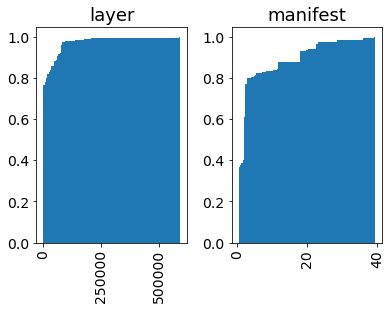

In [37]:
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 15}
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig = ibm_prod_get.hist(column='size', by='document_type', cumulative=True, density=1, bins=100)
# plt.show()

plt.savefig("plots/3.5gb/cdf-get.png", bbox_inches='tight')
#ibm_prod_get_manifest.hist(cumulative=True, density=1, bins=100)
#ibm_prod_get_layer.hist(cumulative=True, density=1, bins=100)

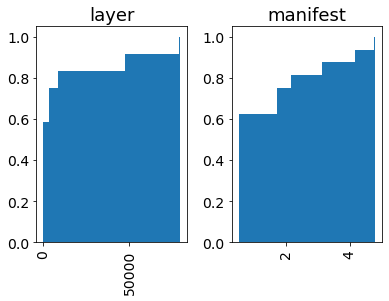

In [38]:
ibm_prod_put.hist(column='size', by='document_type', cumulative=True, density=1, bins=100)
plt.savefig("plots/3.5gb/cdf-put.png", bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

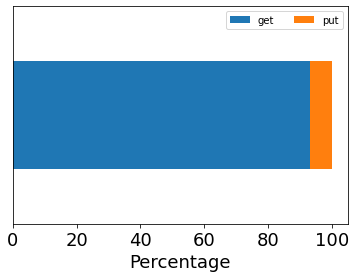

<Figure size 432x288 with 0 Axes>

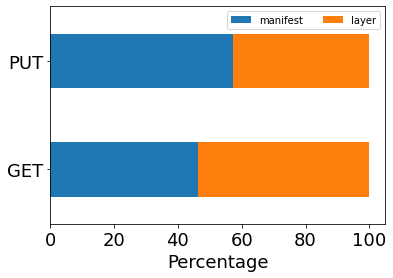

In [39]:
total_get_count = len(ibm_prod_get.index)
get_percentage = (total_get_count / len(ibm_prod_trace.index) )* 100
total_put_count = len(ibm_prod_put.index)
put_percentage = (total_put_count / len(ibm_prod_trace.index)) * 100


get_layer_count = len(ibm_prod_get[ibm_prod_get['document_type'] == 'layer'].index)
get_layer_percentage = (get_layer_count / total_get_count) * 100

get_manifest_count = len(ibm_prod_get[ibm_prod_get['document_type'] == 'manifest'].index)
get_manifest_percentage = (get_manifest_count / total_get_count) * 100

put_layer_count = len(ibm_prod_put[ibm_prod_put['document_type'] == 'layer'].index)
put_layer_percentage = (put_layer_count / total_put_count) * 100

put_manifest_count = len(ibm_prod_put[ibm_prod_put['document_type'] == 'manifest'].index)
put_manifest_percentage = (put_manifest_count / total_put_count) * 100

Data_percentage = {'get': [get_percentage], 'put': [put_percentage]}
data_manifest_layer = {'manifest': [get_manifest_percentage, put_manifest_percentage], 'layer': [get_layer_percentage, put_layer_percentage]}
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
df = pd.DataFrame(Data_percentage, columns=['get', 'put'], index=['TOTAL'])
plt.figure()
ax = df.plot.barh(stacked=True, title='')
ax.legend(ncol=len(df.columns))
plt.xlabel('Percentage')
plt.tick_params(axis='y', which='both', bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelleft=False)
plt.savefig("plots/3.5gb/get-put-ratio.png", bbox_inches='tight')



df = pd.DataFrame(data_manifest_layer, columns=['manifest', 'layer'], index=['GET', 'PUT'])
plt.figure()
ax = df.plot.barh(stacked=True, title='')
ax.legend(ncol=len(df.columns))
plt.xlabel('Percentage')
plt.savefig("plots/3.5gb/manifest-layer-ratio.png", bbox_inches='tight')
plt.rc('xtick', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=MEDIUM_SIZE)

In [40]:

for dataframe in dataframes:
    
    dataframes[dataframe] = dataframes[dataframe].sort_values(by=['time'])
    dataframes[dataframe]['registry-name'] = dataframe
    dataframes[dataframe]["time"] = dataframes[dataframe]["time"] - dataframes[dataframe]["time"].iloc[0]
    dataframes[dataframe]["arrival_time"] = dataframes[dataframe]["time"] + dataframes[dataframe]["duration"]
    dataframes[dataframe] = dataframes[dataframe].sort_values(by=['arrival_time'])
    requests_get = dataframes[dataframe][dataframes[dataframe]["method"] == "GET"]["duration"].mean()
    requests_put = dataframes[dataframe][dataframes[dataframe]["method"] == "PUT"]["duration"].mean()
    requests_get_manifest = dataframes[dataframe][dataframes[dataframe]["document_type"] == "manifest"]["duration"].mean()
    requests_get_layer = dataframes[dataframe][dataframes[dataframe]["document_type"] == "layer"]["duration"].mean()
    throughput = len(dataframes[dataframe].index) / dataframes[dataframe]['arrival_time'].iloc[-1]
    Data['Registry'].append(dataframe)
    Data['avg_latency_put'].append(requests_put)
    Data['avg_latency_get'].append(requests_get)
    Data['avg_latency_layer_get'].append(requests_get_layer)
    Data['avg_latency_manifest_get'].append(requests_get_manifest)
    Data['avg_throughput'].append(throughput)
    
    counters = dataframes[dataframe]['arrival_time'].groupby(pd.cut(dataframes[dataframe]['arrival_time'], np.arange(0,int(math.ceil(dataframes[dataframe]['arrival_time'].iloc[-1])),1))).count()
    Data['throughput_data'].append(counters)

<Figure size 432x288 with 0 Axes>

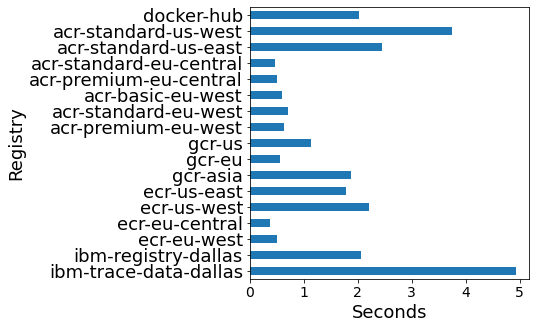

In [41]:
import matplotlib
import matplotlib.pyplot as plt
df = pd.DataFrame(Data,columns=['Registry','avg_latency_get'])
plt.figure()
fig = df.plot(x='Registry', y='avg_latency_get', kind='barh', figsize=(5, 5))
plt.xlabel('Seconds')
fig.get_legend().remove()
plt.savefig('plots/3.5gb/delay_avg_latency_get.png', bbox_inches='tight')

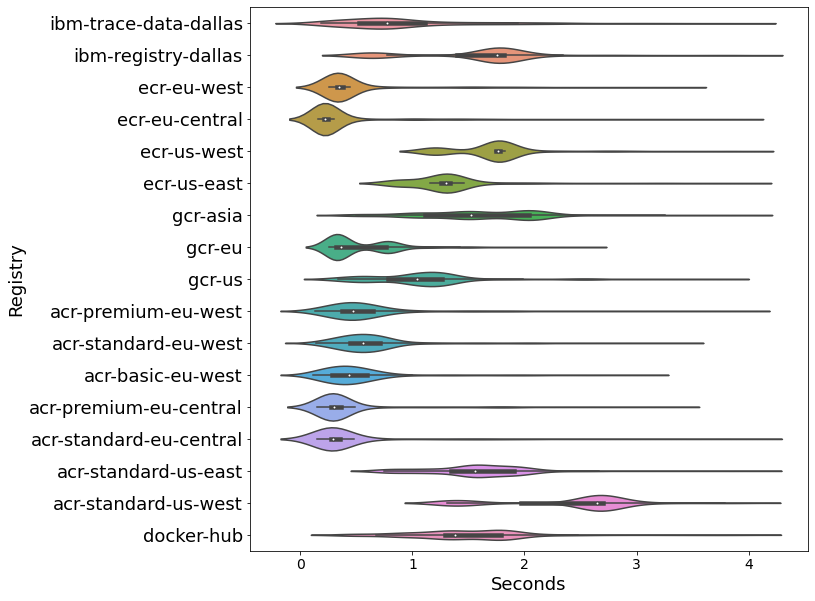

In [42]:
df = pd.concat(dataframes, names=['registry'])
df_get = df[df['method'] == 'GET']
df_get = df_get.loc[df_get.duration < 4]
plt.figure(figsize=(10,10))
# df_get.boxplot(column='duration', by='registry', figsize=(8,7), showfliers=False, vert=False)
p = sns.violinplot(data=df_get, x='duration', y='registry-name', width=1)
plt.xlabel('Seconds')
plt.ylabel('Registry')
plt.suptitle('')
plt.savefig('plots/3.5gb/delay_latency_get_boxplot.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

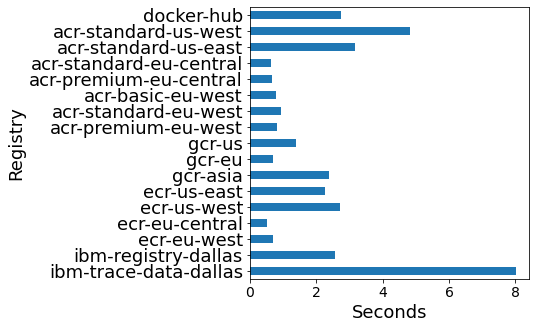

In [43]:
df_lay = pd.DataFrame(Data,columns=['Registry','avg_latency_layer_get'])
plt.figure()
fig = df_lay.plot(x='Registry', y='avg_latency_layer_get', kind='barh', figsize=(5, 5))
plt.ylabel('Registry')
plt.xlabel('Seconds')
fig.get_legend().remove()
plt.savefig('plots/3.5gb/delay_latency_layer_get_boxplot.png', bbox_inches='tight')

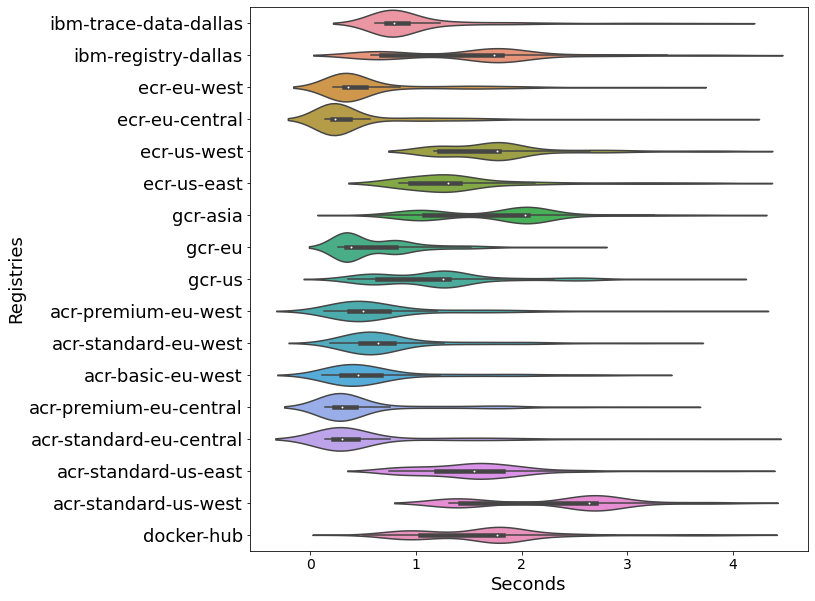

In [44]:

df_layer_get = df_get[df_get['document_type'] == 'layer']
plt.figure(figsize=(10,10))
p = sns.violinplot(data=df_layer_get, x='duration', y='registry-name', width=1)
plt.xlabel('Seconds')
plt.ylabel('Registries')
plt.suptitle('')
plt.savefig('plots/3.5gb/delay_latency_layer_get_boxplot.png', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

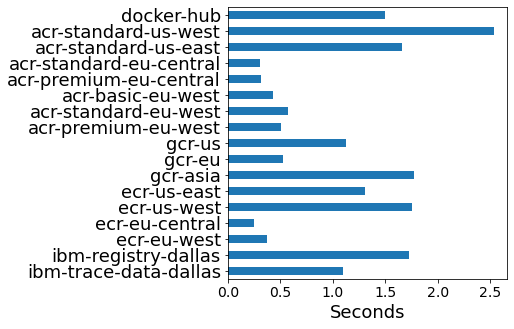

In [45]:

plt.figure(figsize=(10,10))
df_man = pd.DataFrame(Data,columns=['Registry','avg_latency_manifest_get'])
fig = df_man.plot(x='Registry', y='avg_latency_manifest_get', kind='barh', figsize=(5, 5))

plt.xlabel('Seconds')
plt.ylabel('')
plt.suptitle('')
fig.get_legend().remove()
plt.savefig('plots/3.5gb/delay_latency_manifest_get.png', bbox_inches='tight')

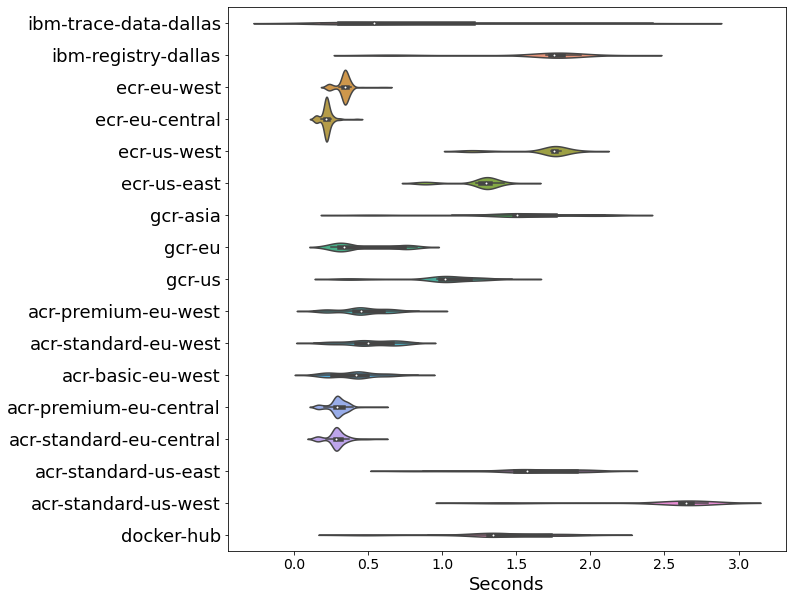

In [46]:

plt.figure(figsize=(10,10))
df_man_get = df_get[df_get['document_type'] == 'manifest']
df_man_get = df_man_get[df_man_get.duration < 2.8]
# fig = .boxplot(column='duration', by='registry', figsize=(8,7), showfliers=False, vert=False)
p = sns.violinplot(data=df_man_get, x='duration', y='registry-name', width=1.4)
plt.xlabel('Seconds')
plt.ylabel('')
# plt.tick_params(axis='y', which='both', bottom=False,      # ticks along the bottom edge are off
#     left=False,         # ticks along the top edge are off
#     labelleft=False)
plt.suptitle('')
plt.savefig('plots/3.5gb/delay_latency_manifest_get_boxplot.png', bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

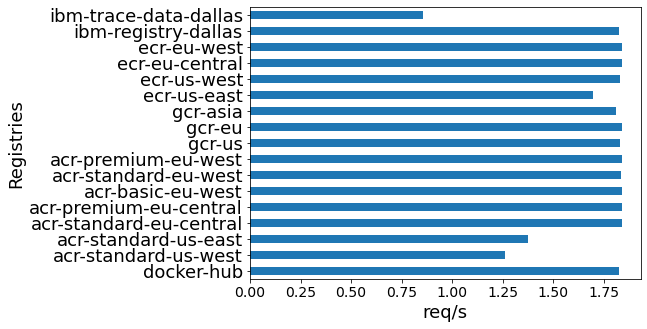

In [47]:
plt.figure()
df_throughput = pd.DataFrame(Data,columns=['Registry','avg_throughput'])
fig = df_throughput.plot(x='Registry', y='avg_throughput', kind='barh', figsize=(7, 5))
plt.xlabel('req/s')
plt.ylabel('Registries')
plt.suptitle('')
fig.invert_yaxis()
fig.get_legend().remove()
plt.savefig('plots/3.5gb/throughput_avg_delay.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

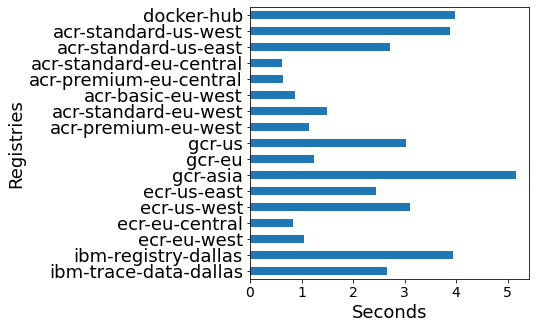

In [48]:
plt.figure()
df_put = pd.DataFrame(Data,columns=['Registry','avg_latency_put'])
fig = df_put.plot(x='Registry', y='avg_latency_put', kind='barh', figsize=(5, 5))
plt.xlabel('Seconds')
plt.ylabel('Registries')
plt.suptitle('')
fig.get_legend().remove()
plt.savefig('plots/3.5gb/delay_avg_latency_put.png', bbox_inches='tight')

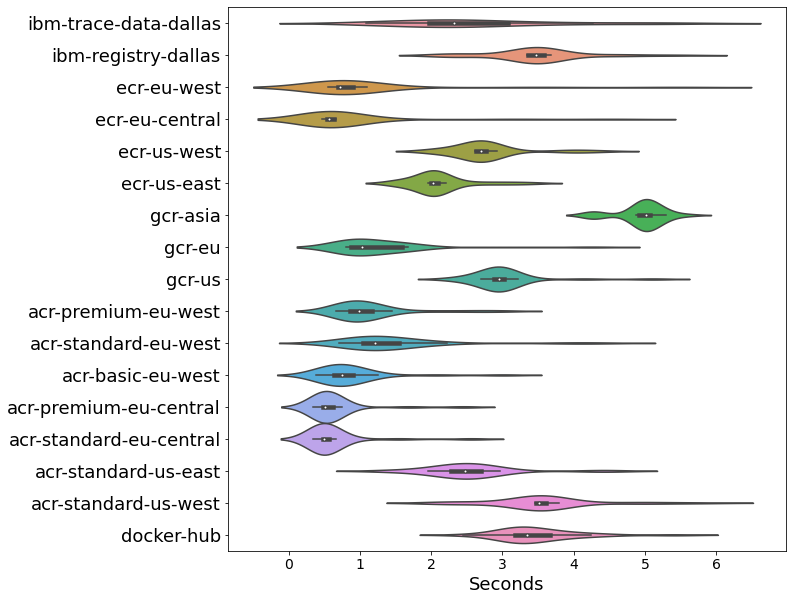

In [49]:
plt.figure(figsize=(10,10))
df_put = df[df['method'] == 'PUT']
df_put = df_put[df_put.duration < 6]
# df_put.boxplot(column='duration', by='registry', figsize=(8,7), showfliers=False, vert=False)
p = sns.violinplot(data=df_put, x='duration', y='registry-name', width=1)
plt.xlabel('Seconds')
plt.ylabel('')
plt.suptitle('')
plt.savefig('plots/3.5gb/delay_latency_put_boxplot.png', bbox_inches='tight')